# Toxic Comments

This notebook attempts to classify bad comments on Wikipedia, for Kaggle challenge https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge. The technique is a non-tensorflow implementation called Naive Bayes SVM, the original implementation is from https://www.kaggle.com/jhoward/nb-svm-strong-linear-baseline. I use these functions and try out other models using the feature set to see if a higher AUC can be obtained.  

First load the datasets.

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer

train_data = pd.DataFrame(pd.read_csv("./train.csv"))
test_data = pd.DataFrame(pd.read_csv("./test.csv"))

Have a look at the structure of the training set and partition the training data into features and labels. Afterwards plot the distribution of the target labels to view the prevelance of certain types of labels. Toxic comments appear 9.5% of the time, insult and obscene material 5% of the time while some of the more controversial content makes up less than 1% of the data. There is evidently class imbalances.

In [2]:
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\r\nWhy the edits made under my use...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\r\nMore\r\nI can't make any real suggestions...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
X = train_data[["comment_text"]]
y = train_data[["toxic","severe_toxic", "obscene", "threat", "insult", "identity_hate"]]

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

df_y_train = pd.DataFrame(y)
df_y_train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


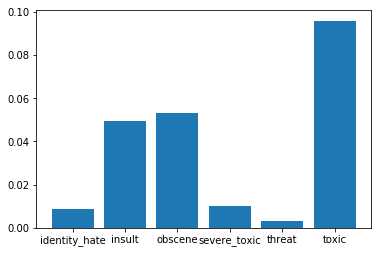

In [5]:
import matplotlib.pyplot as plt
proportions = [sum(df_y_train[col]) / len(df_y_train) for col in df_y_train.columns]
plt.bar(df_y_train.columns, proportions)
plt.show()

In order to work with the text data we must remove any punctuation and markers from the text, so that they can be tokenized correctly. Onced cleaned we pass the text into the term frequency inverse document frequency transformer.

In [6]:
import re, string

token = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s):
    return token.sub(r' \1 ', s).split()

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer(min_df=3,
                             max_df=0.9,
                             lowercase=True, 
                             analyzer = 'word', 
                             stop_words='english', 
                             dtype=np.float32, 
                             tokenizer = tokenize, 
                             strip_accents='unicode',
                             use_idf = 1,
                             smooth_idf=1,
                             sublinear_tf=1)
tfidf_train_data = tfidf_vect.fit_transform(train_data.comment_text)
tfidf_testing_data = tfidf_vect.transform(test_data.comment_text)

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV

This is the Naive baives feature function which is then used to transform the features.

In [9]:
def prob(y_i, y):
    p = tfidf_train_data[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum() + 1)

In [10]:
import copy

def create_model(y, model):
    y = y.values
    r = np.log(prob(1, y) / prob(0, y))
    model = copy.deepcopy(model)
    x_nb = tfidf_train_data.multiply(r)
    return model.fit(x_nb, y), r

In [19]:
def log_model(y):
    y = y.values
    r = np.log(prob(1, y) / prob(0, y))
    model = LogisticRegression(C=4, dual=True)
    x_nb = tfidf_train_data.multiply(r)
    return model.fit(x_nb, y), r

column_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
predictions_log = np.zeros((len(test_data), len(column_names)))
for i, j in enumerate(column_names):
    m, r = log_model(y[j])
    predictions_log[:,i] = m.predict_proba(tfidf_testing_data.multiply(r))[:,1]

In [13]:
from sklearn.calibration import CalibratedClassifierCV

column_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
def svc_model(y):
    y = y.values
    r = np.log(prob(1, y) / prob(0, y))
    model = LinearSVC()
    model = CalibratedClassifierCV(model)
    x_nb = tfidf_train_data.multiply(r)
    return model.fit(x_nb, y), r

predictions_svc = np.zeros((len(test_data), len(column_names)))
for i, j in enumerate(column_names):
    m, r = svc_model(y[j])
    predictions_svc[:,i] = m.predict_proba(tfidf_testing_data.multiply(r))[:,1]

In [17]:
column_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
def forest_model(y):
    y = y.values
    r = np.log(prob(1, y) / prob(0, y))
    model = RandomForestClassifier()
    x_nb = tfidf_train_data.multiply(r)
    return model.fit(x_nb, y), r

predictions_forest = np.zeros((len(test_data), len(column_names)))
for i, j in enumerate(column_names):
    m, r = forest_model(y[j])
    predictions_forest[:,i] = m.predict_proba(tfidf_testing_data.multiply(r))[:,1]

In [20]:
predictions_aggregate = np.zeros((len(test_data), len(column_names)))

predictions_aggregate[:,i] = (predictions_log[:,i] + predictions_svc[:,i] + predictions_forest[:,i]) / 3

In [22]:
import time
timestr = time.strftime("%Y-%m-%d %H%M")

subm = pd.read_csv('./sample_submission.csv')
test_submission = pd.DataFrame({'id': subm["id"]})
submission = pd.concat([test_submission, pd.DataFrame(predictions_aggregate, columns = column_names)], axis=1)
submission.to_csv('submission%s.csv' % timestr, index=False)

Train Logistic regression models for each column.

In [ ]:
column_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
predictions_logistic = np.zeros((len(testing_data), len(column_names)))

param_grid = {
             'C': [1, 5, 10, 20],
             'class_weight': ['balanced']
             }

for i, col in enumerate(column_names):
    gridsearch_log = GridSearchCV(LogisticRegression(), param_grid = param_grid, cv=3)
    
    gridsearch_log.fit(tfidf_train_data, y[col])
    predictions_logistic[:,i] = gridsearch_log.predict(tfidf_testing_data)
    
predictions_logistic

Train SVM models for each column

In [ ]:
column_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
predictions_svm = np.zeros((len(testing_data), len(column_names)))

param_grid = {'gamma': [0.1, 1, 5, 10]
             'C': [1, 5, 10, 20]
             }

for i, col in enumerate(column_names):
    gridsearch_svm = GridSearchCV(SVC(), param_grid = param_grid, cv=3)
    
    gridsearch_svm.fit(tfidf_train_data, y[col])
    predictions_svm[:,i] = gridsearch_svm.predict(tfidf_testing_data)
    
predictions_sv,

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

y_val_df = pd.DataFrame(y_val, columns = column_names)
predictions = [predictions_logistic]
for prediction in predictions:
    print('----------------')
    for column in prediction.columns:
        print(column, roc_auc_score(y_val_df[column], prediction[column]))

In [ ]:
import pandas as pd
predictions_df = pd.DataFrame(np.c_[testing_data.id,predictions_logistic])
predictions_df.columns = ['id', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
predictions_df.to_csv("test_predictions.csv",index=False)
predictions_df.head()